Exercise 9: Supersymmetry, part II
==================================

Again, we will classify (simulated) events from the LHC as either  **background** 
(label `0`) or **signal** (label `1`) for the purposes of SUSY.
The dataset is the same as for the last exercise: there are 18 `variables` observed in each event (the explanations are given in `variable_names`).  The [dataset] has 5,000,000 events, generated from simulations, together with their true classification (`labels`).

This time, instead of a logistic classification model, we are going to use a
**feed-forward neural network**.

[dataset]: https://www.nature.com/articles/ncomms5308

In [2]:
import os
import numpy as np
import matplotlib.pyplot as pl

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-i08iceh3 because the default path (/home/e00473828/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# Load the dataset from a binary file
with np.load(os.path.expanduser("~/shared/susy.npz")) as _datafile:
    labels = _datafile["labels"].astype(int)
    variables = _datafile["variables"].astype(float)
    variable_names = list(_datafile["variable_names"].astype(str))

Before we actually implement the NN, let us first think about its topology.

Given the SUSY data set and the setup in our lecture, describe the Neural Network
you are going to use:

 1. How many neurons do we need in the input layer and how many in the output layer? Why?
 2. Do we need to use a hidden layer and if so, why?
 3. Which activation function is most useful in the hidden layers and which one shall
    we use in the output layer? 

## 1)
Input neurons: 18 (one for each variable)

output neurons: 1 (only 1 classification needed: background or signal)

## 2)
If the problem did not require a hidden layer then that would mean there is a simple linear mapping between the input parameters and the output. If the problem were really that simple then this approach is a bit overkill. So I think we definitely need at least 1 hidden layer.

The choice of NN depth and width however, is a giant trade-off battle and a-priori I don't think we can say too much definitively. The grid search later will help us determine how many hidden layers we need and how wide they should be.

## 3)
#### Hidden Layer Activation function: ReLU
Has a bigger gradient on average than the logistic function and thus enables faster training. Logistic function gets a bit stuck when the neurons are nearly saturated.

#### Output Layer Activation function: Sigmoid Function (logistic)
Because it is easier to train with GD than a hard cutoff model and also gives a measure of confidence in the output rather than just a best guess.



Train neural network
----------------------------

Use scikit-learn to construct and train a neural network model. 

 1. again split the data into training and test set.
Keep in mind that training neural networks is expensive.  Since you probably do not want
to wait forever  for the training to finish, please for now put only 1 - 5 % of
data into the training set and the rest into the test set.

 2. construct a neural network model (use `sklearn.neural_network.MLPClassifier`).
To keep the training process fast, start with a small number of hidden neurons
(no more than 50 overall).  The training process is almost identical to a logistic
model (you can use the same functions).  Be sure to use early stopping.

 3. Predict data on the test set. Print or plot the confusion matrix, the accuracy,
 sensitivity and specificity.

In [4]:
import sklearn.neural_network
import sklearn.metrics

In [5]:
# Step 1: Split data 
cutoff = int(0.02 * len(labels))

X_train = variables[:cutoff, :]
y_train = labels[:cutoff]

X_test = variables[cutoff:, :]
y_test = labels[cutoff:]

In [6]:
# Step 2: Construct and train model

# set topology
hidden_layers = 2
neurons_per_layer = 50 // hidden_layers

# create and train model
classifier = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[neurons_per_layer for _ in range(hidden_layers)], early_stopping=True)
classifier.fit(X_train, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=[25, 25])

Accuracy: 0.799354693877551
Sensitivity: 0.7088184233392748
Specificity: 0.8757119618621687
Background-to-signal ratio:	 1.186 : 1


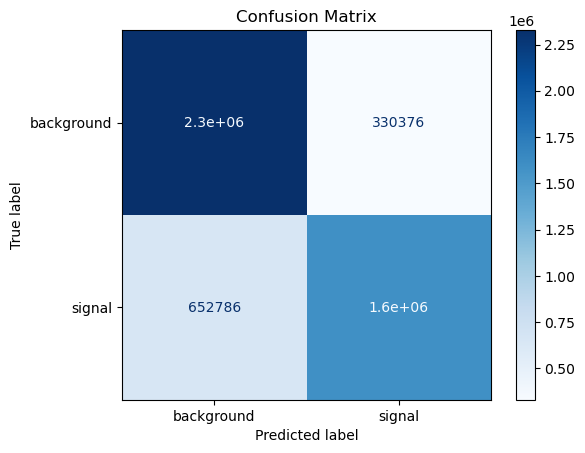

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score

# Step 3: Predict data, print confusion matrix and metrics
yhat_test = classifier.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, yhat_test)
ConfusionMatrixDisplay(cm, display_labels=['background', 'signal']).plot(cmap='Blues');
pl.title("Confusion Matrix")

# scores
tn, fp, fn, tp = cm.ravel()

print("Accuracy:", accuracy_score(y_test, yhat_test))
print("Sensitivity:", recall_score(y_test, yhat_test))
print("Specificity:", tn / (tn + fp))
print(f"Background-to-signal ratio:\t {(tn + fp) / (fn+tp):.3f} : 1")

One other thing we can plot is the validation error over the epoch
number (called `validation_score_`) of the model.  Do that below:

Text(0.5, 0, 'epoch number')

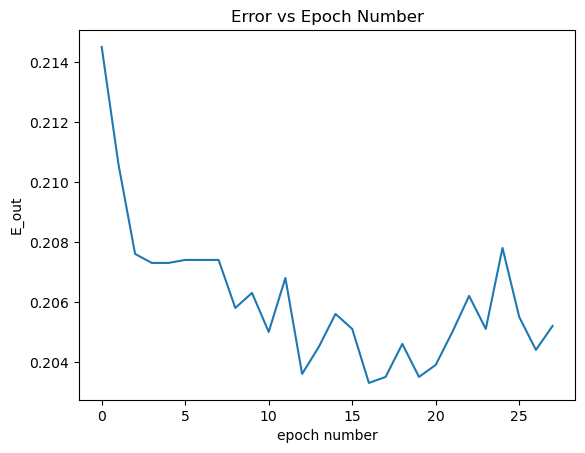

In [10]:
val_scores = classifier.validation_scores_

pl.plot([1- x for x in val_scores])

pl.title('Error vs Epoch Number')
pl.ylabel('E_out')
pl.xlabel('epoch number')

In [ ]:
GS

Perform grid search
--------------------------
With the training process set up, let us try a grid search
by hand.   Choose two hyperparameters of either your model
or your training process, choose three values for each of
the parameters and run the training process above for all
nine combinations.

Create in the table with the validation error for each
combination, and summarize your findings.  You should find 
a template for the table in the cell below:

| P/Q |   Q1 |   Q2 |   Q3 |
| --- | ---- | ---- | ---- |
|  P1 | ? | ? | ? |
|  P2 | ? | ? | ? |
|  P3 | ? | ? | ? |

| Hidden Layers/Regularization |   $10^{-4}$ |   $10^{-3}$ |   $10^{-2}$ |
| --- | ---- | ---- | ---- |
|  6 | 0.79773 | 0.79728 | 0.7995 |
|  3 | 0.79654 | 0.79817 | 0.79831 |
|  1 | 0.79734 | 0.79846 |0.79994 |

In [ ]:
def train_and_score(hL, reg):
    # create model
        classifier = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[50 // hL for _ in range(hL)], early_stopping=True, alpha=reg)
        # train model
        classifier.fit(X_train, y_train)
        # calc score
        return classifier.score(X_train, y_train)

# vary number of hidden layers hL, and number of maximum hidden neurons allowed
GS = [[train_and_score(hL, reg) for hL in [6, 3, 1]] for reg in [1e-4, 1e-3, 1e-2]]

In [ ]:
pl.pcolormesh(GS)
pl.colorbar()

for i, hL in enumerate([6, 3, 1]):
    for j, reg in enumerate([1e-4, 1e-3, 1e-2]):
        pl.text(i+0.5,j+0.5, f"depth: {hL}\nreg: {reg}\n{GS[j][i]}",
                ha='center',va='center',
                size=10,color='w')
        
pl.title('Grid Search')
pl.xlabel('NN Depth (depth)')
pl.ylabel('regularisation term (reg)')

pl.gca().set_xticks([])
pl.gca().set_yticks([]);


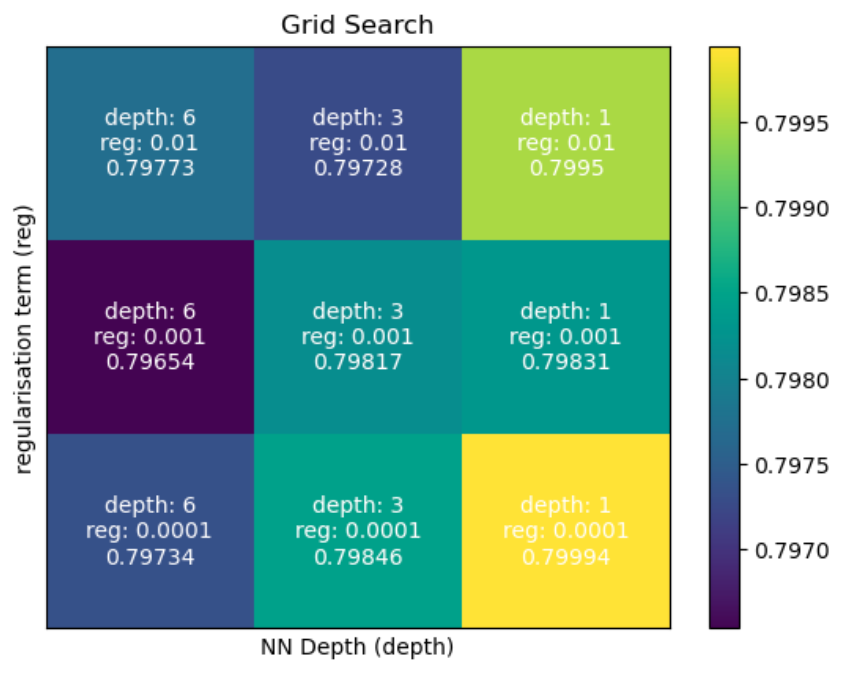
When validating the cell that computes the grid search times out, so I'll just put this screenshot here just in case it does not run on your end (if that is something you even do)

Summary
-------------
You should find that it is difficult to get the accuracy above 80 %, barely
higher than for the logistic model.

 1. Give two possible reasons for this behaviour.
    
 2. You complain to a friend about this problem.  They say: "Just add neurons.
    This makes the model more powerful and thus always leads to an improvement."
    Specify a theoretical and a practical reason why this is not always true.

### 1)
**a)** All the models we used had at most 50 hidden neurons. Maybe this problem is simply too complex to capture with our "small" models because the patterns in the data are so complex. So possibly just throwing more horsepower at the problem and a giant network could fix the issue, but from my limited testing I doubt it because generally the bigger networks did not do much better than the smaller ones.

**b)** Maybe the dataset itself contains some noise and thus those extra 20% that we can not seem to predict are purely random and there is no pattern underlying them, and thus we can never predict them accurately

### 2)
**Theoretical:**
If we simply increase the size of our model we also increase the likelyhood that we just overfit the training data, and thus do not see improvements when validating with the test set. Particularly if like in 1b) the data really does contain some noise then we will simply start fitting the noise in the training set which will only hurt the performance of the model when applied to the validation set.

**Practical**
Making the model bigger also means making the model harder to train. At some point it would simply become too resource intensive to train, and considering that the benefits may be tiny or even non existent this simply wouldn't not be economical.